# Data Pre-processing

Lets read the data we gatherd and convert it to a dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from yelphelpers import *

warnings.filterwarnings('ignore')

with open('vancouver_restaurants.json') as f:
    data = json.load(f)
    
with open('categories.json') as f:
    cats = json.load(f)

In [2]:
df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,XXEhaKrcgD4YcK9Q9rq8ww,afghan-chopan-restaurant-richmond,Afghan Chopan Restaurant,https://s3-media1.fl.yelpcdn.com/bphoto/-5b_2p...,False,https://www.yelp.com/biz/afghan-chopan-restaur...,56,"[{'alias': 'afghani', 'title': 'Afghan'}]",4.0,"{'latitude': 49.1654853820801, 'longitude': -1...",[],$$,"{'address1': '8260 Westminster Hwy', 'address2...",+16042786555,+1 604-278-6555,10971.641804
1,dnE7mGrs1lWMdbhmhcfINA,simba-s-grill-burnaby,Simba’s Grill,https://s3-media3.fl.yelpcdn.com/bphoto/mkxb_o...,False,https://www.yelp.com/biz/simba-s-grill-burnaby...,5,"[{'alias': 'african', 'title': 'African'}]",4.0,"{'latitude': 49.254592042411, 'longitude': -12...",[],NaN,"{'address1': '201-3300 Boundary Road', 'addres...",+16049740649,+1 604-974-0649,6832.040303
2,bFt8He20VyAlh55iK3Tn3Q,sumerian-grill-surrey,Sumerian Grill,https://s3-media2.fl.yelpcdn.com/bphoto/-35lJ4...,False,https://www.yelp.com/biz/sumerian-grill-surrey...,19,"[{'alias': 'turkish', 'title': 'Turkish'}, {'a...",4.5,"{'latitude': 49.196568, 'longitude': -122.8455...",[],NaN,"{'address1': '10671 King George Boulevard', 'a...",+16044970332,+1 604-497-0332,20987.003812
3,Z5M3ei1dEUfHlELEO7Xy1g,thai-by-thai-surrey-3,Thai By Thai,https://s3-media2.fl.yelpcdn.com/bphoto/UDiodW...,False,https://www.yelp.com/biz/thai-by-thai-surrey-3...,82,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':...",4.0,"{'latitude': 49.1698001, 'longitude': -122.890...",[],$$,"{'address1': '9164 120 Street', 'address2': ''...",+16045935244,+1 604-593-5244,19449.797325
4,_3FBR7yCFDfeDeLsyWrPbQ,the-union-vancouver,The Union,https://s3-media2.fl.yelpcdn.com/bphoto/LNMKFy...,False,https://www.yelp.com/biz/the-union-vancouver?a...,215,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",4.0,"{'latitude': 49.2777861723342, 'longitude': -1...",[],$$,"{'address1': '219 Union Street', 'address2': '...",+16045683230,+1 604-568-3230,2044.358802


In [3]:
print("Missing data:")
df.isnull().sum()

Missing data:


id                  0
alias               0
name                0
image_url           0
is_closed           0
url                 0
review_count        0
categories          0
rating              0
coordinates         0
transactions        0
price            1059
location            0
phone               0
display_phone       0
distance            0
dtype: int64

# Cleaning the data

Here, we need to:
- Remove unnecessary data
- One-hot encode categories list
- Convert string data into numeric data (rating, price)
- Add neighbourhood name based on zip code

In [4]:
#  Remove unnecessary data
df = df.drop(columns=['image_url','is_closed','transactions','phone','display_phone'])

# Replace restruarant price tags ($) with numerical values
df.replace(['$','$$','$$$','$$$$'],[1.0,2.0,3.0,4.0], inplace=True)


# Expand the list, "categories", into separate columns (one-hot encoding)
df_categories = df[['id', 'categories']]
df.drop(columns=['categories'],inplace=True)
df.rename(columns={'alias':'r_alias'},inplace=True)

df_expanded = df.merge(expand_list(df_categories, 'categories'))
df_categories = expand_list(df_categories,'categories')
df_categories = pd.concat([df_categories.drop(['categories'], axis=1), df_categories['categories'].apply(pd.Series)], axis=1)
df_categories = df_categories.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()

df = df.merge(df_categories, on='id')
df = df.drop('alias', 1).join(df.alias.str.join('|').str.get_dummies())


# To find categorical data, we need to split restaurants with multiple categories into separate entries.
df_expanded = pd.concat([df_expanded.drop(['categories'], axis=1), df_expanded['categories'].apply(pd.Series)], axis=1)

# Clean up some variables to leave more space
df_categories = None

In [5]:
df.head()

,id,r_alias,name,url,review_count,rating,coordinates,price,location,distance,...,turkish,ukrainian,vegan,vegetarian,venezuelan,venues,vietnamese,waffles,whiskeybars,wine_bars
0,XXEhaKrcgD4YcK9Q9rq8ww,afghan-chopan-restaurant-richmond,Afghan Chopan Restaurant,https://www.yelp.com/biz/afghan-chopan-restaur...,56,4.0,"{'latitude': 49.1654853820801, 'longitude': -1...",2.0,"{'address1': '8260 Westminster Hwy', 'address2...",10971.641804,...,0,0,0,0,0,0,0,0,0,0
1,dnE7mGrs1lWMdbhmhcfINA,simba-s-grill-burnaby,Simba’s Grill,https://www.yelp.com/biz/simba-s-grill-burnaby...,5,4.0,"{'latitude': 49.254592042411, 'longitude': -12...",NaN,"{'address1': '201-3300 Boundary Road', 'addres...",6832.040303,...,0,0,0,0,0,0,0,0,0,0
2,bFt8He20VyAlh55iK3Tn3Q,sumerian-grill-surrey,Sumerian Grill,https://www.yelp.com/biz/sumerian-grill-surrey...,19,4.5,"{'latitude': 49.196568, 'longitude': -122.8455...",NaN,"{'address1': '10671 King George Boulevard', 'a...",20987.003812,...,1,0,0,0,0,0,0,0,0,0
3,Z5M3ei1dEUfHlELEO7Xy1g,thai-by-thai-surrey-3,Thai By Thai,https://www.yelp.com/biz/thai-by-thai-surrey-3...,82,4.0,"{'latitude': 49.1698001, 'longitude': -122.890...",2.0,"{'address1': '9164 120 Street', 'address2': ''...",19449.797325,...,1,0,0,0,0,0,0,0,0,0
4,_3FBR7yCFDfeDeLsyWrPbQ,the-union-vancouver,The Union,https://www.yelp.com/biz/the-union-vancouver?a...,215,4.0,"{'latitude': 49.2777861723342, 'longitude': -1...",2.0,"{'address1': '219 Union Street', 'address2': '...",2044.358802,...,0,0,0,0,0,0,0,0,0,0


# Summary Statistics

### Overall assessment of review_count, rating and price
Here, we take a look at the general statistics for restuarant data

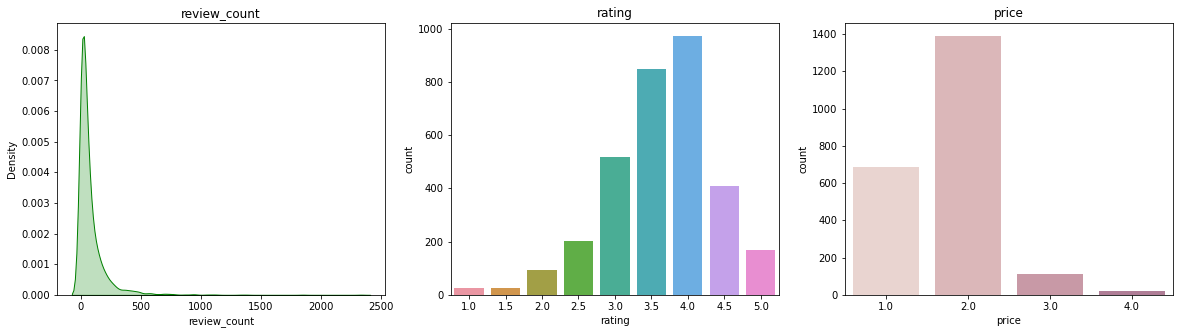

In [6]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot(df['review_count'], hist=False, color="g", ax=axes[0], kde_kws={"shade": True}).set_title('review_count')
sns.countplot(df['rating'],ax=axes[1]).set_title('rating')
sns.countplot(df['price'],ax=axes[2]).set_title('price')
plt.show()

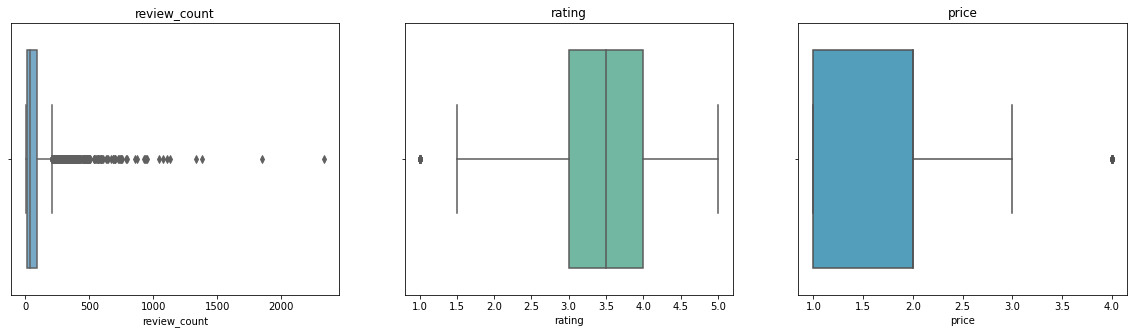

In [7]:
# Boxplots to identify outliers
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(df['review_count'],ax=axes[0],palette='Blues').set_title('review_count')
sns.boxplot(df['rating'],ax=axes[1], palette='BuGn_r').set_title('rating')
sns.boxplot(df['price'],ax=axes[2], palette='GnBu_d').set_title('price')
plt.show()

### Categorical assessment of review_count, rating, price and total number of restuarants
Here we find the above statistics by category. The Bayesian averge of each property was used to graph it by category in descending order.

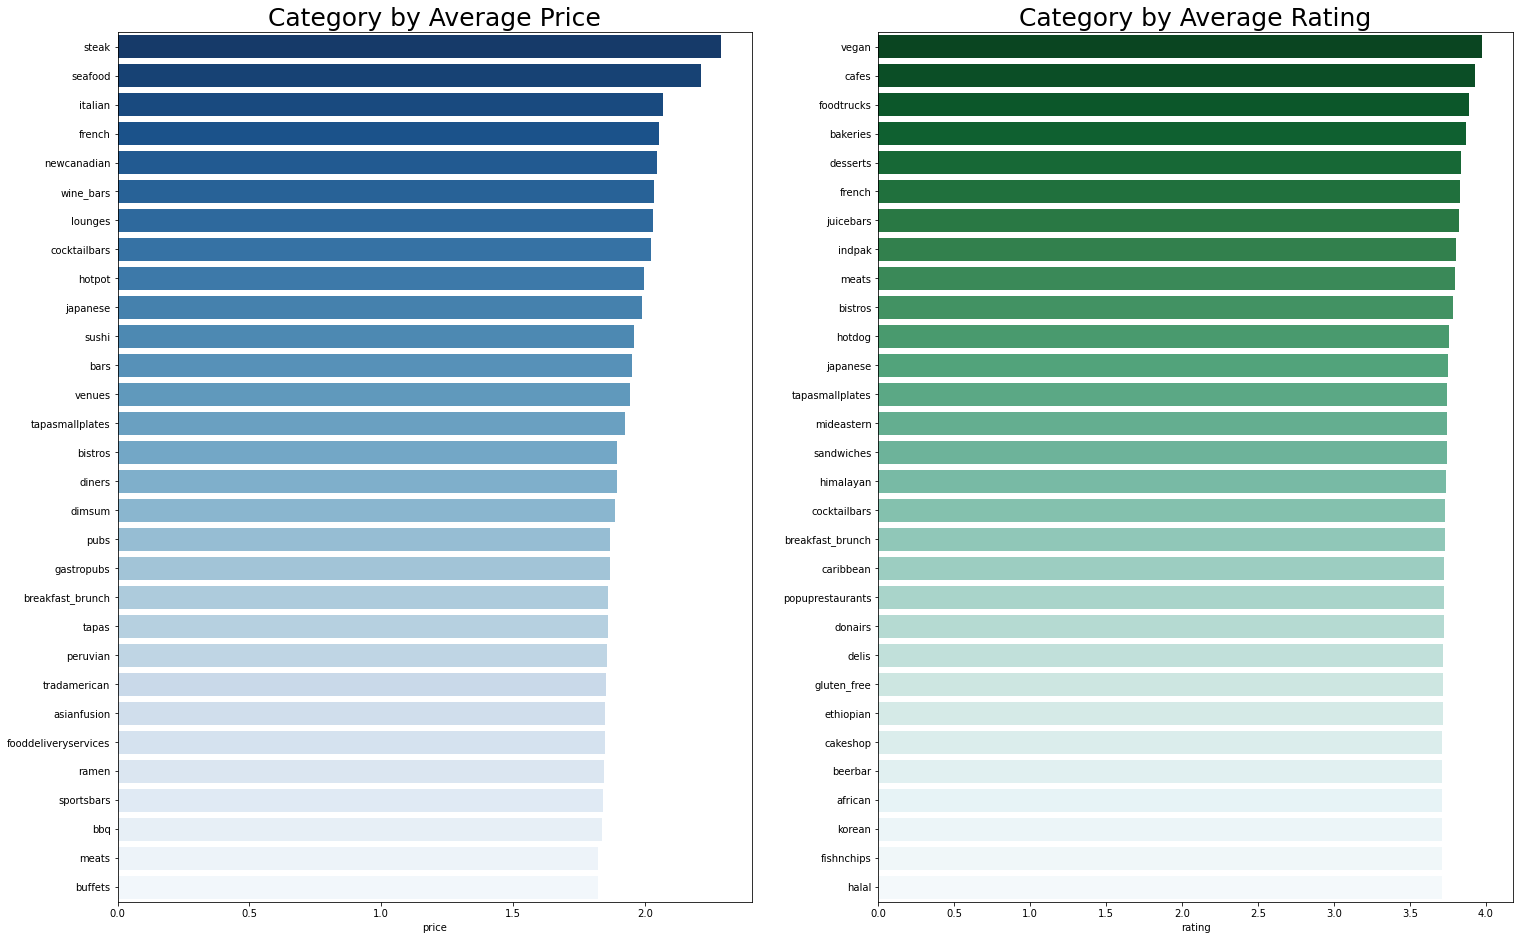

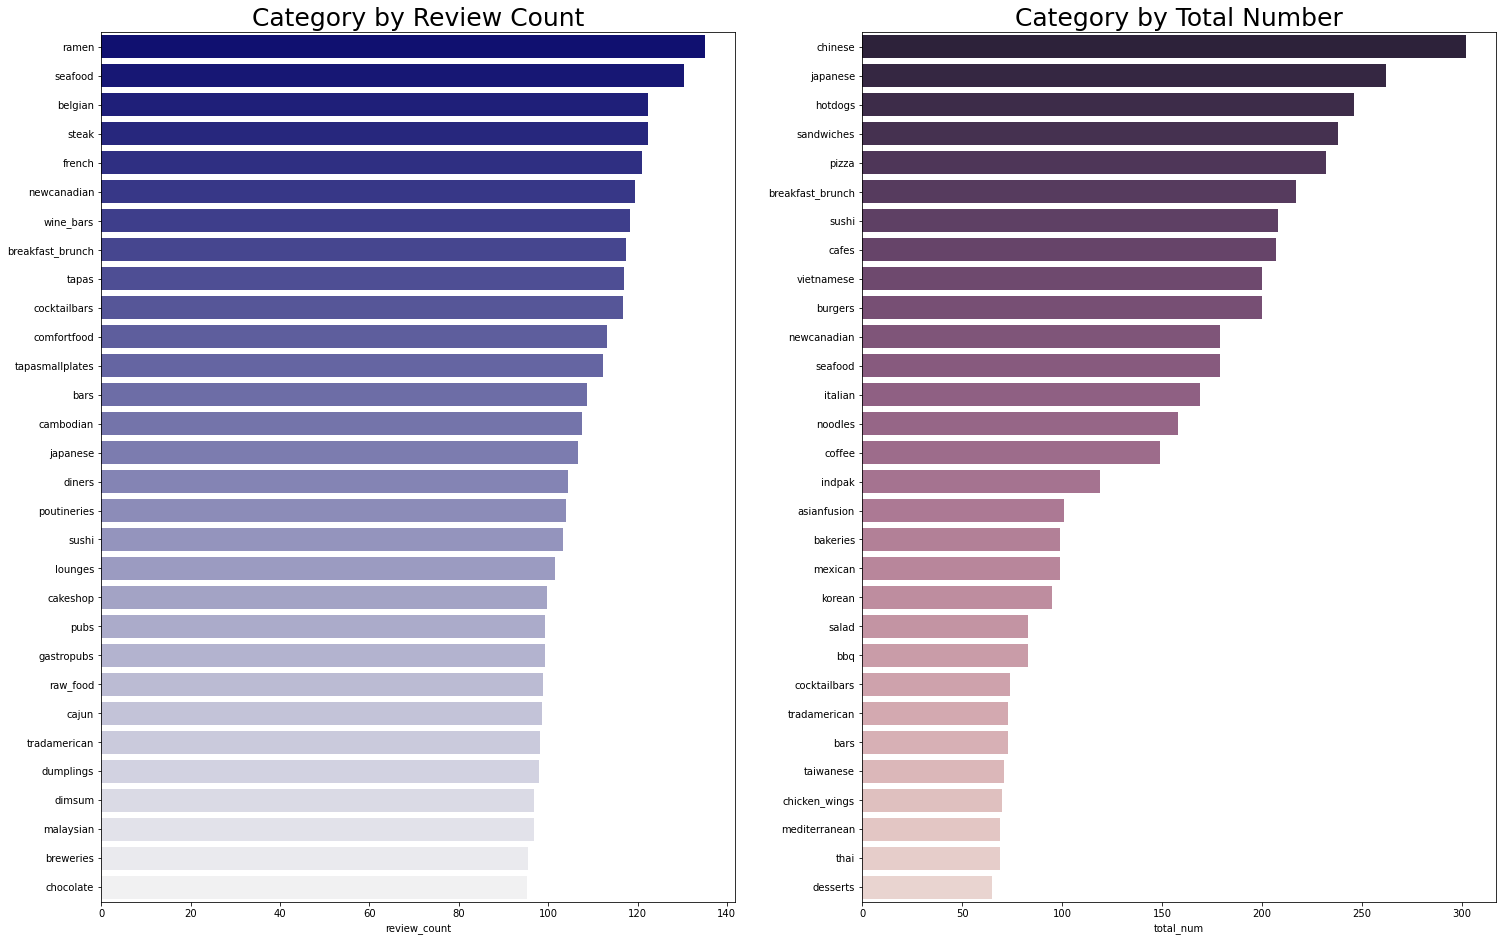

In [8]:
n = 30

### PRICE ###
pr = (bayes_avg(df_expanded.dropna(how='any'), 'alias', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:n]
### RATING
ra = (bayes_avg(df_expanded, 'alias', 'rating').sort_values(ascending=False)
     .reset_index().sort_values('rating', ascending=False))
ra = ra.iloc[:n]
### REVIEW_COUNT
re = (bayes_avg(df_expanded, 'alias', 'review_count').sort_values(ascending=False)
     .reset_index().sort_values('review_count', ascending=False))
re = re.iloc[:n]
### NUMBER OF RESTAURANTS
nu = (df.drop(['id', 'r_alias', 'name','url','review_count','rating','coordinates','price','location', \
         'distance', 'title'], axis=1).sum().sort_values(ascending=False))
nu = nu.reset_index().iloc[:n]
nu.rename(columns={'index': 'alias', 0:'total_num'}, inplace=True)




# first fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=n, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

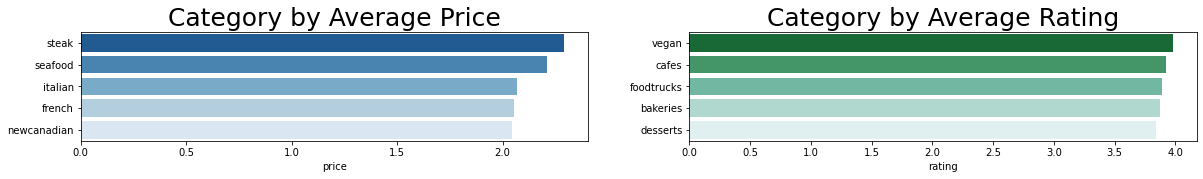

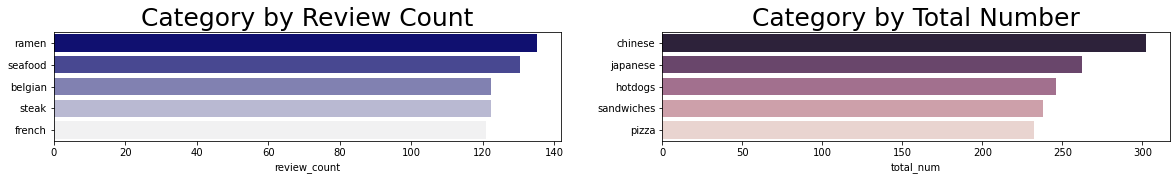

In [9]:
# let's map the top 5 of each category
m = 5

pr,ra,re,nu = pr.iloc[:m], ra.iloc[:m], re.iloc[:m], nu.iloc[:m]

#first fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette(sns.cubehelix_palette(8))

sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=m, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()


# Geographic Data
geojson file that has Vancouver sip code boundary coordinates can be found [here](https://github.com/codeforgermany/click_that_hood/blob/main/public/data/vancouver.geojson).

This [site](https://www.geonames.org/postal-codes/CA/BC/british-columbia.html) contains the zip codes and the area names in Vancouver. So I matched the names from geojson file to the coresponding area names.

In [10]:
# Run this in cmd opend as Administrator to install folium package
# conda install -c conda-forge/label/gcc7 folium

In [11]:
import folium

with open('vancouver.geojson',) as f:
    geojson = json.load(f)


# edit current dataframe to be readable by folium
df['zip_code'] = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)['zip_code']

In [12]:
df['location'].apply(pd.Series).head()

,address1,address2,address3,city,zip_code,country,state,display_address
0,8260 Westminster Hwy,,,Richmond,V6Y 2B8,CA,BC,"[8260 Westminster Hwy, Richmond, BC V6Y 2B8, C..."
1,201-3300 Boundary Road,,None,Burnaby,V6G 2L7,CA,BC,"[201-3300 Boundary Road, Burnaby, BC V6G 2L7, ..."
2,10671 King George Boulevard,None,,Surrey,V3T 2X6,CA,BC,"[10671 King George Boulevard, Surrey, BC V3T 2..."
3,9164 120 Street,,,Surrey,V3V 4B5,CA,BC,"[9164 120 Street, Surrey, BC V3V 4B5, Canada]"
4,219 Union Street,,,Vancouver,V6A 0B4,CA,BC,"[219 Union Street, Vancouver, BC V6A 0B4, Canada]"


### Applying zip code to location

In [13]:
df['length'] = df['zip_code'].apply(lambda x: len(x))
df['length'].value_counts()

7    3146
3      92
0      25
5       3
Name: length, dtype: int64

In [14]:
df[df.length==5]['zip_code']

93      77581
94      77581
1525    98281
Name: zip_code, dtype: object

Looks like the zip data comes in different lengths.
- zip codes that have a length of 3 and 7 are in postal code format. 
- Zip codes with length 5 are in the form of American zip codes. 
- Because there are only 25 missing zip codes, we will ignore those.

In [15]:
df['location'].apply(pd.Series)[['city','zip_code']]

,city,zip_code
0,Richmond,V6Y 2B8
1,Burnaby,V6G 2L7
2,Surrey,V3T 2X6
3,Surrey,V3V 4B5
4,Vancouver,V6A 0B4
...,...,...
3261,Burnaby,V5C 3Z6
3262,Burnaby,V5H 4P2
3263,Richmond,V6Y 2B6
3264,Richmond,V6Y 1K3


In [16]:
def zip_to_location(zip_code):
    zip_to_loc_dict = {"V6N": "Dunbar Southlands",
                       "V5K": "Hastings-Sunrise",
                       "V5T": "Mount Pleasant",
                       "V6Z": "Downtown",
                       "V6B": "Downtown",
                       "V7X": "Downtown",
                       "V7Y": "Downtown",
                       "V6E": "West End",
                       "V6G": "West End",
                       "V7T": "West End",
                       "V5S": "Killarney",
                       "V6M": "Kerrisdale",
                       "V5X": "Sunset",
                       "V6P": "Marpole",
                       "V6K": "Kitsilano",
                       "V6R": "Kitsilano",
                       "V6J": "Fairview",
                       "V5P": "Victoria-Fraserview",
                       "V6S": "West Point Grey",
                       "V5W": "Oakridge",
                       "V5R": "Renfrew-Collingwood",
                       "V5M": "Renfrew-Collingwood",
                       "V5V": "Riley Park",
                       "V5Y": "Riley Park",
                       "V6H": "Shaughnessy",
                       "V5L": "Grandview-Woodland",
                       "V5N": "Kensington-Cedar Cottage",
                       "V6L": "Arbutus Ridge",
                       "V5Z": "South Cambie",
                       "V6A": "Downtown Eastside"}
    
    if len(zip_code) == 5 or len(zip_code) == 0:
        return ''
    else:
        return zip_to_loc_dict.get(zip_code[:3], zip_code[:3])

    return "None" 

df['area'] = df['zip_code'].apply(zip_to_location)

In [17]:
df['area']

0                     V6Y
1                West End
2                     V3T
3                     V3V
4       Downtown Eastside
              ...        
3261                  V5C
3262                  V5H
3263                  V6Y
3264                  V6Y
3265                  V5H
Name: area, Length: 3266, dtype: object

In [18]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=11
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'rating'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

In [19]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=11
)
df_total_by_zip = df.groupby(['area']).size().reset_index()
vancouver_map.choropleth(geo_data=geojson, data=df_total_by_zip, columns=['area', 0], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

In [20]:
print("Amount of missing price data: {}".format(df.price.isnull().sum()))
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'price'], key_on='feature.properties.name', 
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

Amount of missing price data: 1057


In [21]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'review_count'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map